# Set Libraries

In [4]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import datetime
import pandas as pd
import seaborn as sns
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import pylab
from dateutil.parser import parse

## Function which extracts the date information from filename to be used as a 'time' dimension label for each image
- load MAIAC data in using the rasterio_to_xarray function (Wilson,...)
- extract date and time information from the filename of the MAIAC images
- use the datetime library to strip the time and convert into the necessary format, specifying the format the date/time is currently in

In [1]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

# Validating Southampton Centre
## Extracting MAIAC data for the pixel in which the groundsite is located
- specify the folders in which the AOT data are in
- Create a for loop which goes through each year's folder one by one
    - Create a list of the files within the folder
    - run the maiac_file_to_da function on each element of the list
    - Make the MAIAC data three dimensional, with time as the third dimension
    - Order the data by time
    - Select data for Chilbolton Pixel and save measurements in a dataframe
    - Save the dataframe of the measurements as a csv, using the append mode

In [ ]:
folders = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\20*')

In [ ]:
for folder in folders:
    files = glob.glob(r'{fname}\*_PM25.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_PM25 = xr.concat(list_of_das, 'time')
    reordered_MAIAC_PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))
    Measurements = reordered_MAIAC_PM25.isel(x=1106, y=1048).dropna('time').to_dataframe(name='MAIAC_PM25')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

## Read in AURN data
- Read in AURN data, parsing dates
- Create a new column 'had24' to identify observations that were taken at 24:00
- Replace the 24:00 with 00:00- the correct time format as recognised by the pandas and datetime libraries
- Format the timestamp column to be day/month/year hour:minute:second
- Find observations which 'had24' and add one day to the date/time
- Set index to time

In [2]:
AURN_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Southampton2008_2014.csv', 
                         parse_dates = {'timestamp': ['Date', 'Time']}, infer_datetime_format=True, dayfirst=True, na_values=['No data'])

In [3]:
AURN_Soton['Had24'] = AURN_Soton.timestamp.str.contains(' 24:')

In [4]:
AURN_Soton['timestamp'] = AURN_Soton.timestamp.str.replace(' 24:', ' 00:')

In [5]:
AURN_Soton['timestamp'] = pd.to_datetime(AURN_Soton.timestamp, format='%d/%m/%Y %H:%M:%S')

In [6]:
AURN_Soton.loc[AURN_Soton.Had24, 'timestamp'] = AURN_Soton.query('Had24 == True').timestamp + pd.Timedelta('1d')

In [7]:
AURN_Soton = AURN_Soton.set_index('timestamp')

In [8]:
AURN_Soton.head()

,PM2.5_Soton_Centre,Status,Had24
timestamp,,,
2008-11-06 01:00:00,26.0,V ugm-3 (TEOM FDMS),False
2008-11-06 02:00:00,18.0,V ugm-3 (TEOM FDMS),False
2008-11-06 03:00:00,19.0,V ugm-3 (TEOM FDMS),False
2008-11-06 04:00:00,22.0,V ugm-3 (TEOM FDMS),False
2008-11-06 05:00:00,25.0,V ugm-3 (TEOM FDMS),False


In [9]:
AURN_Soton.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\AURN_Soton.csv')

## Read in MAIAC data
- parse dates using the time variable
- set the index to time
- create a 10minute buffer to be used in the merging of the MAIAC and AERONET data

In [10]:
MAIAC_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', parse_dates=['time'])

In [11]:
MAIAC_Soton = MAIAC_Soton.set_index('time')

In [12]:
MAIAC_Soton.head()

,x,y,MAIAC_PM25
time,,,
2000-02-25 10:50:00,442096.9763,112420.7018,23.026955
2000-02-28 11:25:00,442096.9763,112420.7018,36.062874
2000-03-03 12:35:00,442096.9763,112420.7018,20.079552
2000-12-03 12:30:00,442096.9763,112420.7018,25.816568
2000-08-04 10:35:00,442096.9763,112420.7018,27.164116


In [13]:
MAIAC_Soton['time'] = MAIAC_Soton.index

In [14]:
MAIAC_Soton = MAIAC_Soton.drop_duplicates(subset='time')

In [15]:
MAIAC_Soton = MAIAC_Soton.sort_index()

In [16]:
indexed = MAIAC_Soton.reindex(AURN_Soton.index, method='nearest', tolerance='10Min').dropna()

## Merge the AURN and MAIAC data 
- Merge using the 10minute buffer
- Rename columns to ensure easier identification of the data
- Remove columns that are not needed

In [17]:
soton_result = pd.merge(AURN_Soton, indexed, left_index=True, 
                  right_index=True).reset_index().rename(columns={'time':'AURN_Time', 
                                                                  'timestamp':'Date', 'PM2.5_Soton_Centre':'AURN', 'MAIAC_PM25': 'MAIAC'})

In [18]:
soton_result = soton_result[['Date', 'AURN_Time', 'AURN', 'MAIAC']].dropna()

In [19]:
soton_result[:10]

,Date,AURN_Time,AURN,MAIAC
0,2008-11-11 11:00:00,2008-11-11 10:50:00,10.0,12.274618
1,2008-11-25 11:00:00,2008-11-25 11:00:00,8.0,8.841886
2,2008-11-25 13:00:00,2008-11-25 12:50:00,5.0,8.425797
3,2008-12-01 11:00:00,2008-12-01 10:50:00,9.0,5.013084
4,2008-12-02 12:00:00,2008-12-02 11:55:00,6.0,5.804315
5,2008-12-03 13:00:00,2008-12-03 13:05:00,18.0,14.432179
6,2008-12-04 12:00:00,2008-12-04 12:10:00,6.0,20.042711
7,2008-12-04 14:00:00,2008-12-04 14:00:00,6.0,20.336378
8,2008-12-10 14:00:00,2008-12-10 14:05:00,10.0,3.511345
9,2008-12-17 12:00:00,2008-12-17 12:05:00,6.0,4.569387


In [20]:
soton_result = soton_result.set_index('Date')

In [21]:
soton_result.isnull().sum()

AURN_Time    0
AURN         0
MAIAC        0
dtype: int64

## Create the statistics needed to validate the MAIAC and AURN data
- Line graph showing the variation in AOT data collected by both sites over time
- New variable 'error' to show the discrepencies between the two datasets
- Descriptive statistics
- Histogram of the error
- Calculate RMSE and MAE

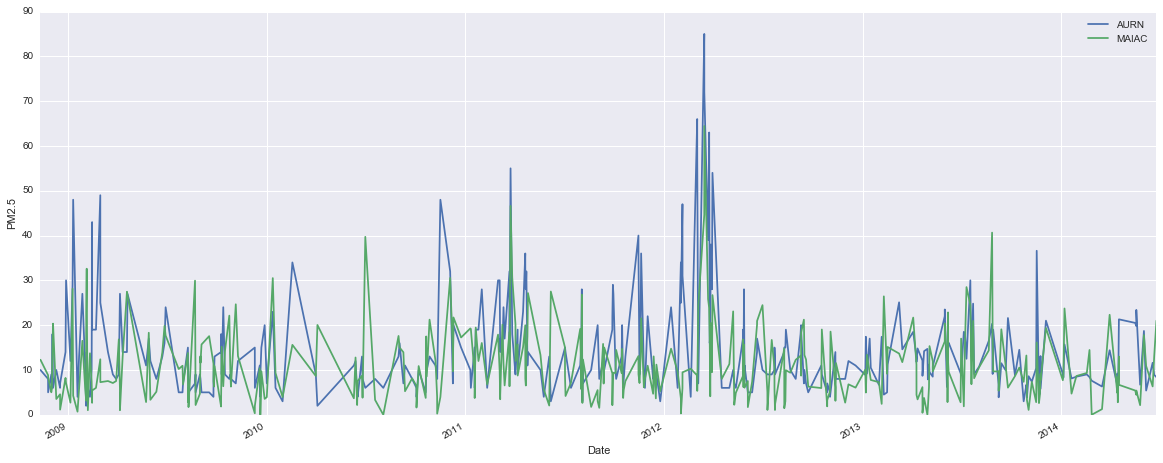

In [22]:
soton_result.plot(figsize=(20, 8))
plt.ylabel('PM2.5')
plt.savefig(r'D:\Annies_Dissertation\Analysis\Soton_validation_graph.jpeg')

In [24]:
soton_result['error'] = soton_result['AURN'] - soton_result['MAIAC']

In [25]:
soton_result.error.abs().describe()

count    362.000000
mean       8.059675
std        8.499346
min        0.038878
25%        2.281614
50%        5.484178
75%       10.943085
max       57.245951
Name: error, dtype: float64

In [26]:
(soton_result.error > 20).sum()

23

In [32]:
soton_result.MAIAC.describe()

count    362.000000
mean      10.937988
std        8.309973
min        0.000000
25%        5.220956
50%        8.942549
75%       15.107771
max       64.451775
Name: MAIAC, dtype: float64

In [33]:
soton_result.AURN.describe()

count    362.000000
mean      14.367127
std       11.175864
min        2.000000
25%        8.000000
50%       11.000000
75%       18.000000
max       85.000000
Name: AURN, dtype: float64

In [34]:
soton_result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_validation.csv')

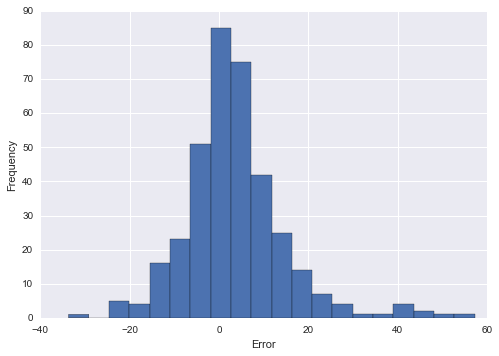

In [35]:
Soton_error_histo = soton_result.error.plot.hist(bins=20)
plt.xlabel('Error')
plt.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_error_histo.jpeg')

In [36]:
rmse = sqrt(mean_squared_error(y_true = soton_result.AURN, y_pred = soton_result.MAIAC))
rmse

11.70460144875577

In [37]:
me = mean_absolute_error(y_true = soton_result.AURN, y_pred = soton_result.MAIAC)
me

8.0596748938287295

### Correlation and Regression

In [38]:
soton_result.corr()

,AURN,MAIAC,error
AURN,1.000000,0.368091,0.724316
MAIAC,0.368091,1.000000,-0.374447
error,0.724316,-0.374447,1.000000


In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(soton_result.AURN,soton_result.MAIAC)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.135490628558
p-value: 4.66373774651e-13
Slope: 0.273698932114


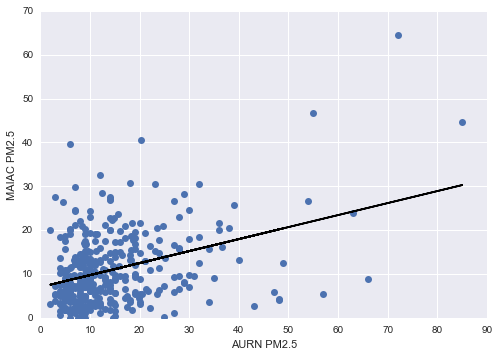

In [40]:
predict_y = intercept + slope * soton_result.AURN

pylab.plot(soton_result.AURN,soton_result.MAIAC, 'o')
pylab.plot(soton_result.AURN, predict_y, 'k-')
pylab.xlabel('AURN PM2.5')
pylab.ylabel('MAIAC PM2.5')
pylab.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_regression.jpeg')

# Validating Bournemouth
## Extracting MAIAC data for the pixel in which the AURN site is located
(As the AURN Bournemouth data is daily averaged we will use the NetCDF daily median MAIAC PM2.5 data that were created using DASK)
- Use xarray to open the netcdf files
- Use the affine information to conver the Easting and Northing coordinates of the Bournemouth AURN site into x and y (row and columns) within the image
- Use the x and y information to extract the PM2.5 data for the pixel 
- Load the results and save to dataframe
- Save the results in the dataframe to csv

In [5]:
PM25 = xr.open_mfdataset(r'C:\MAIACData\nc_monthly_daily\*PM25.nc', concat_dim='time')

In [7]:
a = PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (412322, 93343)

KeyError: 'affine'

In [8]:
ts = PM25['data'].isel(x=1082, y=1063).dropna('time')

In [9]:
ts

<xarray.DataArray 'data' (time: 1421)>
dask.array<getitem..., shape=(1421,), dtype=float32, chunksize=(7,)>
Coordinates:
    x        float64 4.119e+05
    y        float64 9.357e+04
  * time     (time) datetime64[ns] 2000-10-01 2000-10-10 2000-10-12 ...
Attributes:
    affine: [ -9.47639631e+05   1.25654304e+03   0.00000000e+00   1.42927781e+06
   0.00000000e+00  -1.25654304e+03]
    crs: +init=epsg:27700

In [10]:
result = ts.load()

In [11]:
result = result.to_dataframe()

In [ ]:
result.dropna()

In [ ]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25_daily.csv')

## Read in data
- Read in MAIAC data, parsing dates
- Set MAIAC index to the variable time
- read in AURN data, parsing dates
- create a new variable in which to put the properly formatted date/times using the datetime library and specifying day/month/year format
- set the index to the new time variable 
- convert the AURN PM2.5 data to float datatype

In [42]:
MAIAC_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25_daily.csv')

In [43]:
MAIAC_Bmth[:10]

,time,x,y,data
0,2000-10-01,411939.943201,93572.556136,12.497609
1,2000-10-10,411939.943201,93572.556136,10.441040
2,2000-10-12,411939.943201,93572.556136,20.723885
3,2000-10-19,411939.943201,93572.556136,18.034525
4,2000-10-26,411939.943201,93572.556136,8.463571
5,2000-10-30,411939.943201,93572.556136,7.988977
6,2000-10-31,411939.943201,93572.556136,7.751681
7,2000-11-03,411939.943201,93572.556136,11.357734
8,2000-11-04,411939.943201,93572.556136,7.901032
9,2000-11-12,411939.943201,93572.556136,3.061650


In [44]:
MAIAC_Bmth = MAIAC_Bmth.set_index('time')

In [45]:
AURN_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bournemouth2008_2014.csv')

In [46]:
AURN_Bmth[:10]

,Date,PM2.5 particulate matter (Daily measured),Status
0,12/03/2009,0.0,V ugm-3 (GRAV EMFAB)
1,30/11/2009,0.0,V ugm-3 (GRAV EMFAB)
2,25/12/2013,0.0,V ugm-3 (GRAV EMFAB)
3,27/12/2009,1.0,V ugm-3 (GRAV EMFAB)
4,16/02/2010,1.0,V ugm-3 (GRAV EMFAB)
5,22/08/2010,1.0,V ugm-3 (GRAV EMFAB)
6,29/08/2010,1.0,V ugm-3 (GRAV EMFAB)
7,21/09/2010,1.0,V ugm-3 (GRAV EMFAB)
8,17/01/2011,1.0,V ugm-3 (GRAV EMFAB)
9,26/08/2011,1.0,V ugm-3 (GRAV EMFAB)


In [47]:
AURN_Bmth['timestamp'] = pd.to_datetime(AURN_Bmth.Date, format='%d/%m/%Y')

In [48]:
AURN_Bmth = AURN_Bmth.set_index('timestamp')

In [49]:
AURN_Bmth['PM2.5 particulate matter (Daily measured)'].astype(float)

timestamp
2009-03-12     0.00
2009-11-30     0.00
2013-12-25     0.00
2009-12-27     1.00
2010-02-16     1.00
2010-08-22     1.00
2010-08-29     1.00
2010-09-21     1.00
2011-01-17     1.00
2011-08-26     1.00
2011-09-05     1.00
2012-04-29     1.00
2012-12-20     1.00
2012-12-22     1.00
2014-06-04     1.29
2013-09-13     1.50
2013-05-23     1.71
2014-04-06     1.75
2014-01-10     1.88
2014-02-07     1.88
2014-02-19     1.92
2009-03-13     2.00
2009-07-09     2.00
2009-07-11     2.00
2009-07-17     2.00
2009-08-26     2.00
2009-11-02     2.00
2009-11-27     2.00
2009-12-17     2.00
2009-12-26     2.00
              ...  
2012-03-25    34.00
2010-11-06    35.00
2009-01-02    36.00
2009-03-21    36.00
2012-10-24    36.00
2013-04-10    36.17
2013-03-04    36.72
2012-01-31    37.00
2009-01-04    38.00
2009-01-08    38.00
2009-02-24    38.00
2011-03-18    38.00
2012-02-12    38.00
2012-03-14    38.00
2013-04-08    38.67
2012-03-02    40.00
2009-03-18    41.00
2010-01-27    41.00
2014-03-14

### Merge the AURN and MAIAC data for the bournemouth site
- rename columns to ensure easier identification of the data
- set index to date
- remove any unnecessary columns

In [50]:
Bmth_result = pd.merge(AURN_Bmth, MAIAC_Bmth, left_index=True, 
                       right_index=True).reset_index().rename(columns={'data':'MAIAC',
                                                                       'index':'Date', 'Date':'Delete',
                                                                       'PM2.5 particulate matter (Daily measured)':'AURN'})

In [51]:
Bmth_result[:10]

,Date,Delete,AURN,Status,x,y,MAIAC
0,2009-10-08,08/10/2009,6.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,8.424021
1,2009-10-12,12/10/2009,5.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,7.356187
2,2009-10-13,13/10/2009,11.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,11.627522
3,2009-10-14,14/10/2009,12.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,23.966932
4,2009-10-16,16/10/2009,15.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,25.469810
5,2009-10-17,17/10/2009,8.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,20.011995
6,2009-10-18,18/10/2009,13.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,21.040277
7,2009-10-25,25/10/2009,6.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,19.418751
8,2009-10-27,27/10/2009,8.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,9.570953
9,2009-11-04,04/11/2009,3.0,V ugm-3 (GRAV EMFAB),411939.943201,93572.556136,11.654023


In [52]:
Bmth_result = Bmth_result.set_index('Date')

In [53]:
Bmth_result = Bmth_result[['AURN', 'MAIAC']].dropna()

### Create the statistics needed to validate the MAIAC and AURN data
- Line graph showing the variation in AOT data collected by both sites over time
- New variable 'error' to show the discrepencies between the two datasets
- Descriptive statistics
- Histogram of the error
- Calculate RMSE and MAE

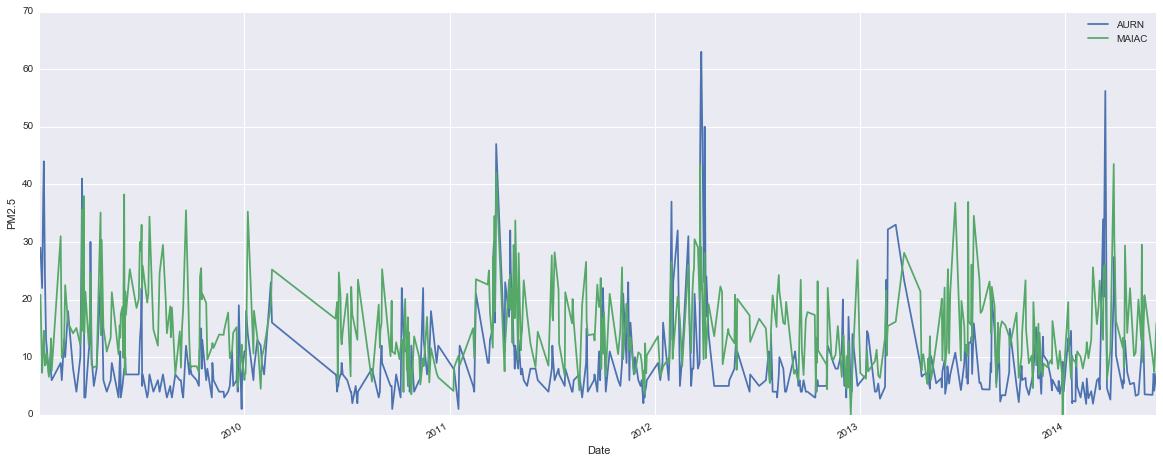

In [54]:
Bmth_result.plot(figsize=(20, 8))
plt.ylabel('PM2.5')
plt.savefig(r'D:\Annies_Dissertation\Analysis\Bmth_validation_graph.jpeg')

In [55]:
Bmth_result['error'] = Bmth_result['AURN'] - Bmth_result['MAIAC']

In [56]:
Bmth_result.error.abs().describe()

count    499.000000
mean       8.147670
std        6.287683
min        0.028516
25%        3.323876
50%        6.650052
75%       11.831492
max       35.325407
Name: error, dtype: float64

In [57]:
Bmth_result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_validation.csv')

In [62]:
Bmth_result.MAIAC.describe()

count    499.000000
mean      14.931897
std        7.431676
min        0.000000
25%        9.575478
50%       13.383366
75%       19.443021
max       43.524334
Name: MAIAC, dtype: float64

In [63]:
Bmth_result.AURN.describe()

count    499.000000
mean      10.097695
std        8.462929
min        1.000000
25%        5.000000
50%        7.250000
75%       12.000000
max       63.000000
Name: AURN, dtype: float64

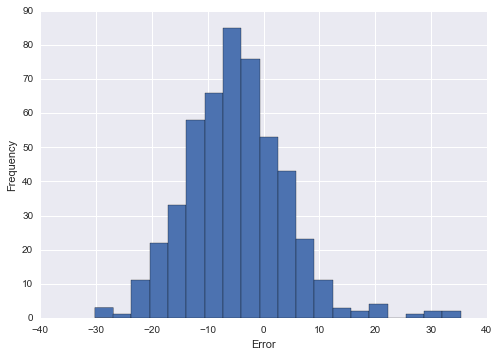

In [64]:
Bmth_error_histo = Bmth_result.error.plot.hist(bins=20)
plt.xlabel('Error')
plt.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_error_histo.jpeg')

In [68]:
rmse = sqrt(mean_squared_error(y_true = Bmth_result.AURN, y_pred = Bmth_result.MAIAC))
rmse

10.287869003548673

In [69]:
me = mean_absolute_error(y_true = Bmth_result.AURN, y_pred = Bmth_result.MAIAC)
me

8.1476695061876683

### Correlation and Regression

In [70]:
Bmth_result.corr()

,AURN,MAIAC,error
AURN,1.000000,0.351503,0.643607
MAIAC,0.351503,1.000000,-0.490287
error,0.643607,-0.490287,1.000000


In [71]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Bmth_result.AURN,Bmth_result.MAIAC)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.123554063475
p-value: 5.87274171914e-16
Slope: 0.308670116971


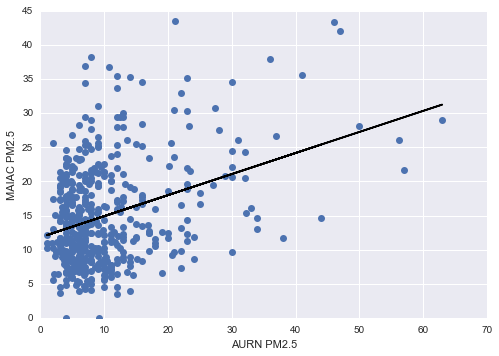

In [72]:
predict_y = intercept + slope * Bmth_result.AURN

pylab.plot(Bmth_result.AURN,Bmth_result.MAIAC, 'o')
pylab.plot(Bmth_result.AURN, predict_y, 'k-')
pylab.xlabel('AURN PM2.5')
pylab.ylabel('MAIAC PM2.5')
pylab.show()
pylab.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_regression.jpeg')